<a href="https://colab.research.google.com/github/it22188236/DL-Labs/blob/main/Lab8/Copy_of_Grifworld_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class GridWorld:
    """Represents the gridworld environment for the reinforcement learning agent."""

    def __init__(self):
        """ Initializes the gridworld with its dimensions, rewards, and terminal states. """
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        # Initialize grid with a default reward of -1 for movement
        self.grid = np.zeros((self.height, self.width)) - 1

        # Set random start location for the agent within the bottom row (excluding last 3 columns)
        self.start_location = (4, np.random.randint(0, 5))
        self.current_location = self.start_location

        # Set locations for the bomb and the gold (terminal states)
        self.bomb_location = (1, 3)
        self.gold_location = (0, 3)
        self.terminal_states = [self.bomb_location, self.gold_location]

        # Set grid rewards for special cells (bomb and gold)
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        """Returns the list of possible actions in the environment."""
        return self.actions

    def agent_on_map(self):
        """Returns a grid representation with the agent's current location marked as 1."""
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for entering a given location."""
        # Ensure the new location is within bounds before returning the reward
        if 0 <= new_location[0] < self.height and 0 <= new_location[1] < self.width:
          return self.grid[new_location[0], new_location[1]]
        else:
          # Return a penalty if the location is out of bounds (should not happen with boundary checks in make_step)
          return -1

    def make_step(self, action):
        """
        Moves the agent in the specified direction.
        Handles boundary conditions: if the agent hits a wall, it stays in the same cell.
        Returns the reward for the move.
        """
        # Store previous location
        last_location = self.current_location
        # Initialize reward with the default movement penalty
        reward = -1

        # Calculate the next intended location based on the action
        x, y = self.current_location
        next_location = self.current_location # Initialize next_location

        if action == 'UP':
            next_location = (x - 1, y)
        elif action == 'DOWN':
            next_location = (x + 1, y)
        elif action == 'LEFT':
            next_location = (x, y - 1)
        elif action == 'RIGHT':
            next_location = (x, y + 1)

        # Check if the next intended location is within the grid boundaries
        if 0 <= next_location[0] < self.height and 0 <= next_location[1] < self.width:
            self.current_location = next_location
            reward = self.get_reward(self.current_location)
        else:
            # If the next location is out of bounds, the agent stays in the current location
            # and receives the reward for the current location (which is -1 for movement)
            reward = self.get_reward(self.current_location)

        return self.current_location, reward # Return the new state and the reward

    def check_state(self):
        """Checks if the agent is in a terminal state (gold or bomb)."""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'
        else:
            return 'NON-TERMINAL'

    def reset(self):
        self.current_location = self.start_location

# Define the play function (assuming this was intended to be here or in a separate cell)
def play(environment, agent, trials=100, max_steps_per_episode=1000, learn=False):
    reward_per_episode = []
    for trial in range(trials):
        environment.reset()
        total_reward = 0
        for step in range(max_steps_per_episode):
            old_state = environment.current_location
            available_actions = environment.actions
            action = agent.choose_action(available_actions)
            new_state, reward = environment.make_step(action) # Use make_step from GridWorld
            if learn:
                agent.learn(old_state, reward, new_state, action)
            total_reward += reward
            if environment.check_state() == 'TERMINAL':
                break
        reward_per_episode.append(total_reward)
    return reward_per_episode

# Define the RandomAgent and Q_Agent for comparison (assuming these were intended to be here or in separate cells)
class RandomAgent():
    def __init__(self):
        pass

    def choose_action(self, available_actions):
        return np.random.choice(available_actions)

    def learn(self, old_state, reward, new_state, action):
        pass # Random agent doesn't learn

class Q_Agent():
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {}
        for x in range(environment.width):
            for y in range(environment.height):
                self.q_table[(x, y)] = {action: 0 for action in environment.actions}

    def choose_action(self, available_actions):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.q_table[self.environment.current_location]
            max_q = max(q_values.values())
            best_actions = [action for action, q in q_values.items() if q == max_q]
            return np.random.choice(best_actions)

    def learn(self, old_state, reward, new_state, action):
        old_q = self.q_table[old_state][action]
        # Need to choose an action for the new state to get its Q-value for the update
        # For Q-learning, this is the max Q-value of the next state
        if new_state in self.q_table:
            max_q_new_state = max(self.q_table[new_state].values()) if self.q_table[new_state] else 0
        else:
             max_q_new_state = 0 # Handle cases where new_state might not be in q_table (e.g., terminal)

        self.q_table[old_state][action] = old_q + self.alpha * (reward + self.gamma * max_q_new_state - old_q)

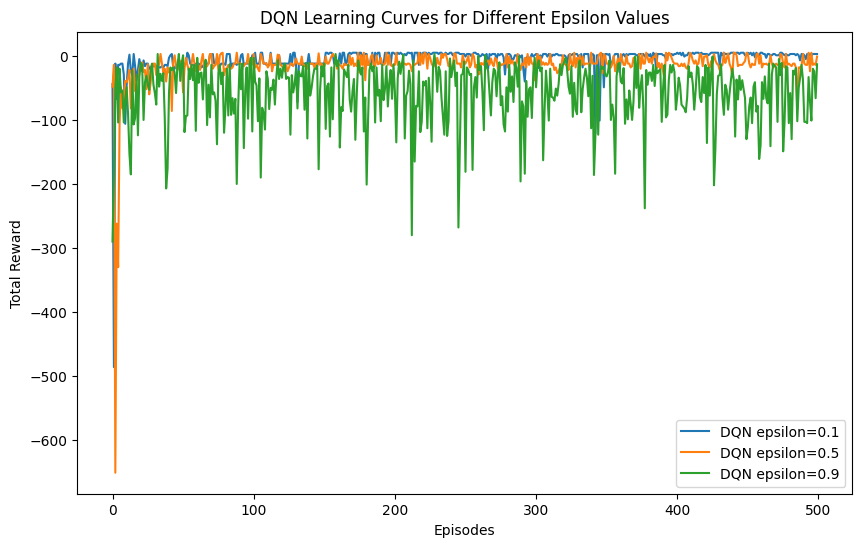

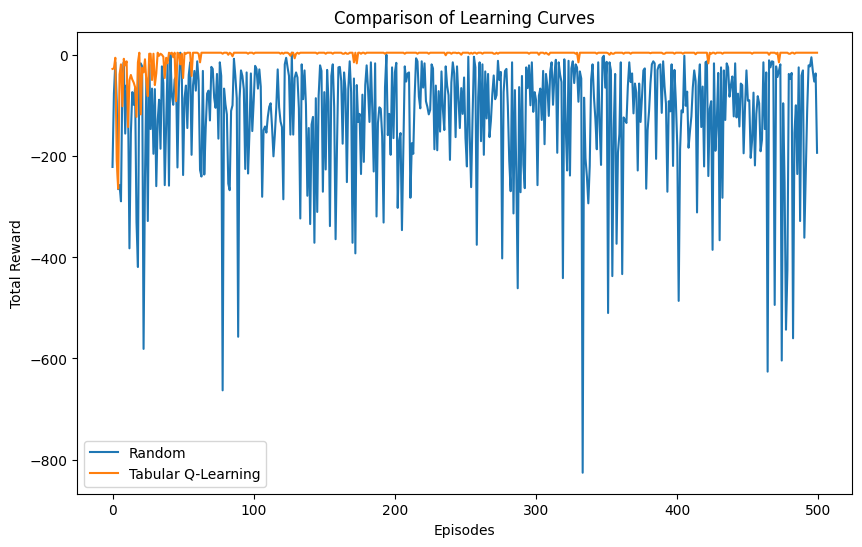

In [ ]:
# This cell will now only contain the DQN related code and plotting.
# The GridWorld, play function, RandomAgent, and Q_Agent definitions are moved or assumed to be in other cells.

# Add this new code cell after the Q_Agent class definition:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN_Agent():
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha  # Kept for compatibility, but not used (lr is used instead)
        self.gamma = gamma
        self.batch_size = 32
        self.lr = 0.001  # Learning rate for optimizer; experiment with 0.1 if needed
        self.buffer_size = 10000
        self.state_dim = 2
        self.action_dim = 4
        self.actions = self.environment.actions
        self.action_map = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3}
        self.idx_to_action = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.replay_buffer = deque(maxlen=self.buffer_size)
        self.steps = 0
        self.update_frequency = 100

    def choose_action(self, available_actions):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(available_actions)
        state = self.environment.current_location
        state_tensor = self.state_to_tensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        action_idx = q_values.argmax().item()
        return self.idx_to_action[action_idx]

    def state_to_tensor(self, state):
        # Normalize state coordinates
        return torch.tensor([state[0] / self.environment.height, state[1] / self.environment.width], dtype=torch.float32)

    def learn(self, old_state, reward, new_state, action):
        done = self.environment.check_state() == 'TERMINAL'
        self.replay_buffer.append((old_state, action, reward, new_state, done))
        if len(self.replay_buffer) > self.batch_size:
            self.update_q_network()

    def update_q_network(self):
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.stack([self.state_to_tensor(s) for s in states])
        next_states = torch.stack([self.state_to_tensor(s) for s in next_states])
        actions = torch.tensor([self.action_map[a] for a in actions], dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values * (1 - dones)
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        if self.steps % self.update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())


# Add this markdown cell after the tabular Q-learning plot:
## Deep Q-Learning (DQN) with Different Epsilon Values

# Add this code cell for running DQN with different epsilons and plotting:
environment = GridWorld()
epsilons = [0.1, 0.5, 0.9]
plt.figure(figsize=(10, 6)) # Create a new figure for DQN plot
for epsilon in epsilons:
    agentDQN = DQN_Agent(environment, epsilon=epsilon, alpha=0.1, gamma=1)
    reward_per_episode = play(environment, agentDQN, trials=500, max_steps_per_episode=1000, learn=True)
    plt.plot(reward_per_episode, label=f'DQN epsilon={epsilon}')
plt.title('DQN Learning Curves for Different Epsilon Values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

# (Optional) To include random and tabular for full comparison:
plt.figure(figsize=(10, 6)) # Create a new figure for comparison plot
agent_random = RandomAgent()
reward_random = play(environment, agent_random, trials=500, learn=False)
plt.plot(reward_random, label='Random')

agent_q = Q_Agent(environment, epsilon=0.05, alpha=0.1, gamma=1)
reward_q = play(environment, agent_q, trials=500, learn=True)
plt.plot(reward_q, label='Tabular Q-Learning')
plt.title('Comparison of Learning Curves')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

In [ ]:
# This cell will now only contain the DQN related code and plotting.
# The GridWorld, play function, RandomAgent, and Q_Agent definitions are moved or assumed to be in other cells.

# Add this new code cell after the Q_Agent class definition:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQN_Agent():
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.epsilon = epsilon
        self.alpha = alpha  # Kept for compatibility, but not used (lr is used instead)
        self.gamma = gamma
        self.batch_size = 32
        self.lr = 0.001  # Learning rate for optimizer; experiment with 0.1 if needed
        self.buffer_size = 10000
        self.state_dim = 2
        self.action_dim = 4
        self.actions = self.environment.actions
        self.action_map = {'UP': 0, 'DOWN': 1, 'LEFT': 2, 'RIGHT': 3}
        self.idx_to_action = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}
        self.q_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network = QNetwork(self.state_dim, self.action_dim)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.replay_buffer = deque(maxlen=self.buffer_size)
        self.steps = 0
        self.update_frequency = 100

    def choose_action(self, available_actions):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(available_actions)
        state = self.environment.current_location
        state_tensor = self.state_to_tensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        action_idx = q_values.argmax().item()
        return self.idx_to_action[action_idx]

    def state_to_tensor(self, state):
        # Normalize state coordinates
        return torch.tensor([state[0] / self.environment.height, state[1] / self.environment.width], dtype=torch.float32)

    def learn(self, old_state, reward, new_state, action):
        done = self.environment.check_state() == 'TERMINAL'
        self.replay_buffer.append((old_state, action, reward, new_state, done))
        if len(self.replay_buffer) > self.batch_size:
            self.update_q_network()

    def update_q_network(self):
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.stack([self.state_to_tensor(s) for s in states])
        next_states = torch.stack([self.state_to_tensor(s) for s in next_states])
        actions = torch.tensor([self.action_map[a] for a in actions], dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values * (1 - dones)
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.steps += 1
        if self.steps % self.update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

# Add this markdown cell after the tabular Q-learning plot:
## Deep Q-Learning (DQN) with Different Epsilon Values

# Add this code cell for running DQN with different epsilons and plotting:
environment = GridWorld()
epsilons = [0.1, 0.5, 0.9]
plt.figure(figsize=(10, 6)) # Create a new figure for DQN plot
for epsilon in epsilons:
    agentDQN = DQN_Agent(environment, epsilon=epsilon, alpha=0.1, gamma=1)
    reward_per_episode = play(environment, agentDQN, trials=500, max_steps_per_episode=1000, learn=True)
    plt.plot(reward_per_episode, label=f'DQN epsilon={epsilon}')
plt.title('DQN Learning Curves for Different Epsilon Values')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

# (Optional) To include random and tabular for full comparison:
plt.figure(figsize=(10, 6)) # Create a new figure for comparison plot
agent_random = RandomAgent()
reward_random = play(environment, agent_random, trials=500, learn=False)
plt.plot(reward_random, label='Random')

agent_q = Q_Agent(environment, epsilon=0.05, alpha=0.1, gamma=1)
reward_q = play(environment, agent_q, trials=500, learn=True)
plt.plot(reward_q, label='Tabular Q-Learning')
plt.title('Comparison of Learning Curves')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

TypeError: cannot unpack non-iterable numpy.float64 object

<Figure size 1000x600 with 0 Axes>